# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [6.0, 6.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
    'savefig.directory':'./Images'
})

### Exercise 04.1

In Statistical Mechanics the Maxwell–Boltzmann distribution (<a href="https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution" target="_blank">Link Wikipedia</a>) is a probability distribution used for describing particle speeds in idealized gases. However, rarefied gases at ordinary temperatures behave very nearly like an ideal gas and the Maxwell–Boltzmann speed distribution is an excellent approximation for such gases. For a 3D system its formula is:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$

By using LJ reduced units (Lenght: $\sigma$; Energy: $\epsilon$; Mass: the mass, $m$, of the particles; Temperature: $\epsilon/k_B$; velocity: $\sqrt{\epsilon/m}$) its form becomes:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

The NSL_SIMULATOR code already computes the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$.

<span style="color:red">Include the calculation of the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, inside your Molecular Dynamics code by using data blocking to obtain single block averages, progressive average values and progressive uncertainties for $p(v^*,T^*)$.</span>

Remember that, the Maxwell–Boltzmann distribution, $p(v^*,T^*)$, can be approximately computed as a **normalized histogram** on an appropriate interval $\left[ 0, v_{max}\right]$ and chosing the number of bins into which you want to divide this interval.

#### Soluzione
Per includere nel codice di Dinamica Molecolare il calcolo della distribuzione di Maxwell-Boltzmann $p(v^*,T^*)$ ho modificato la classe System in diversi punti:
- innanzitutto nel metodo initialize_properties() ho implementato la creazione dei bin per salvare la probabilità delle velocità del sistema. 
- in seguito nel metodo measure() ho calcolato il modulo della velocità di ciascuna particella e ho incrementato il contatore dell'indice del vettore _measurement corrispondente (_index_pofv + int(v/_bin_size_v)). Bisogna stare attenti che se v/_bins_size_v è meggiore nel numero di bin la velocità cadrebbe fuori dall'istogramma. Per risolvere questo problema ho deciso di mettere tutte queste velocità nell'ultimo bin; una scelta altrenativa potrebbe essere quella di eliminare quei valori.
- per completare il calcolo della densità di probabilità aggiungiamo nel metodo average() il calcolo della media a blocchi per ogni bin e il corrispondente errore. Salviamo l'indice del blocco, la velocità corrispondente al bin, il valor medio del numero di elementi in quel bin corrispondenti a quella velocità e l'errore.
- in ultimo ho settato la velocità massima, per farlo inizialmente ho plottato la distribuzione delle velocità che ottenevo lasciando il valore impostato ($4*_temp$), poi vedendno che dopo $v=5$ la distribuzione si appiattiva ho impostato $v_{max} = 5$. Inoltre per calcolare più accuratamnete il valore di$v_{max}$ ho fatto un calcolo analitico considerando $v_{max} = <v> +3\sigma$.
Il valor medio lo calcolo come:

$$ \langle v \rangle = \int_0^{\infty} dv^*  v^* p(v^*,T^*) = 1.6 \sqrt{T^*}$$

La $\sigma$ come:

$$ \sigma^2 = \langle v^2 \rangle - \langle v \rangle^2 $$

dove $\langle v^2 \rangle$ deriva dall'uguaglianza dell'energia cinetica con l'equipartizione dell'energia:
 $$\frac{{v^*}^2}{2} = \frac{3 T^*}{2}$$

Quindi:
$$ v_{max} = (1.6 + 3* \sqrt{ 3-(1.6)^2 } ) \sqrt{T^*} = 3.6 \sqrt{T^*} $$
Poi in realtà nella simulazione ho messo $v_{max} = 5 \sqrt{T^*}$ per ottenere una distribuzione migliore.

Bisogna poi normalizzare la distribuzione ottenuta in modo da poterla confrontare con al distribuzione di Maxwell-Boltzman delle velocità:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

Per normalizzare dividiamo le ordinate per  _n_part*_bin_size_v , che è un'approssimazione dell'area della distribuzione ottenuta. 


 //creazione dell'istogramma
 if(_measure_pofv) {
    for(int i = 0; i<_npart; i++){
      //cout << "la velocità è della particella " << i << " è " << _particle(i).getvelocity(1) << endl;
      double v = sqrt( dot( _particle(i).getvelocity() , _particle(i).getvelocity() ));
      //cout << "la velocità è " << v << endl;
      if(int(v/_bin_size_v) < _n_bins_v){
        // cout << "prova" << i << ": " << _index_pofv + int(v/_bin_size_v) << endl;
        _measurement(_index_pofv + int(v/_bin_size_v))++;
      } else {
        //cout << "Warning: velocity out of range!" << i << endl; 
        _measurement(_index_pofv +_n_bins_v-1)++;
      }
    }
  }

### Exercise 04.2

By means of your upgraded code, <span style="color:red">perform MD simulations via a Lennard-Jones model</span> ( e.g. Argon parameters: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- gas phase: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (cut-off radius: $r_c = 5.0$)

starting from a <span style="color:red">**very low entropic** initial configuration</span>:
1. initial **particle positions**: <span style="color:red">fcc crystal occupying half of the simulation box in each dimension</span>
2. initial **velocity distribution**:  $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$ where $v_{T^*}$ is suitably connected to $T^*$. For example, this condition could be obtained by imposing that every particle has an initial velocity $\pm v_{T^*}$ for **only one** of its velocity components: $v_x$, $v_y$, $v_z$.

The goal is to show that, by evolving such initial condition via a Molecular Dynamics simulation, the velocity distribution tends to approximate the Maxwell–Boltzmann distribution.

- **Produce some pictures that show this convergence**
- The evolution of the system moves towards the increasing of entropy (more homeogeneous configuration of particles)? What would you find by changing the direction of time? Comment on these aspects in your jupyter-notebook

**Note that** the MD simulation will conserve the total energy; thus the kinetic energy and the temperature are not constant of motion ... the comparison should be done with $p(v^*,T^*_{\rm eff})$ where $T^*_{\rm eff}$ is the effective temperature obtained once the system has been equilibrated.

#### Soluzione
Facciamo evolvere il sistema partendo da uno stato a bassa entropia partendo da una configurazione di un cristallo FCC con velocità distribuite con una probabilità: $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$, dove $v_{T^*}$ è la velocità media calcolata come detto sopra.

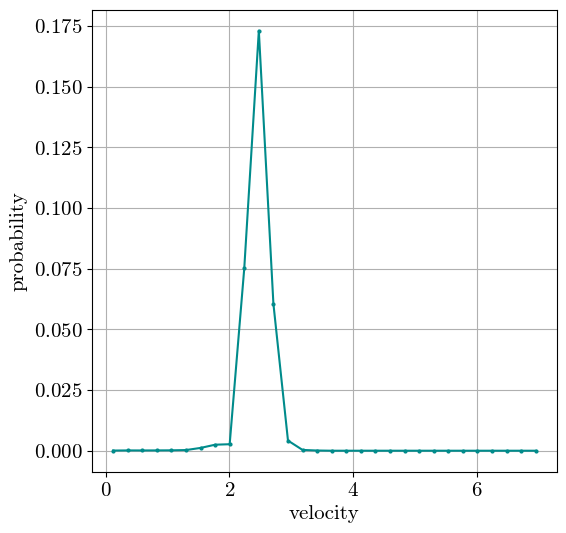

In [3]:
pofv = np.loadtxt("NSL_SIMULATOR/OUTPUT/pofv.dat")
v = pofv[:,1]
prob = pofv[:,2]
err = pofv[:,3]

#normalizzazione della distribuzione
prob /= (108*0.17)
err /= (108*0.17)


plt.figure(1)
#primo frame della simulazione, delta
v_first = pofv[:30,1]
prob_first = pofv[:30,2]
err_first = pofv[:30,3]
plt.figure(1)
plt.errorbar(v_first, prob_first,err_first, marker = 'o', markersize = '2',color='darkcyan', ecolor='lightblue', label = 'last frame')
plt.xlabel('velocity')
plt.ylabel('probability')
plt.grid(True)


Plottando tutti frame insieme vediamo che la distribuzione delle velocità evolve dalla delta verso alla distribuzione di Maxwell-Boltzman.

In [4]:
#caricamento dei dati
pofv = np.loadtxt("NSL_SIMULATOR/OUTPUT/pofv.dat")
v = pofv[:,1]
prob = pofv[:,2]
err = pofv[:,3]

#primo frame della simulazione, delta
v_first = pofv[:30,1]
prob_first = pofv[:30,2]
err_first = pofv[:30,3]

#ultimo frame della simulazione
v_last = pofv[-30:,1]
prob_last = pofv[-30:,2]
err_last = pofv[-30:,3]
#la normalizzazione dovrei averla gia fatta nel c++
#normalizzazione
#prob /= (108*0.17)
#err /= (108*0.17)

#prob_first /= (108*0.17)
#err_first /= (108*0.17)

##prob_last /= (108*0.17)
##err_last /= (108*0.17)

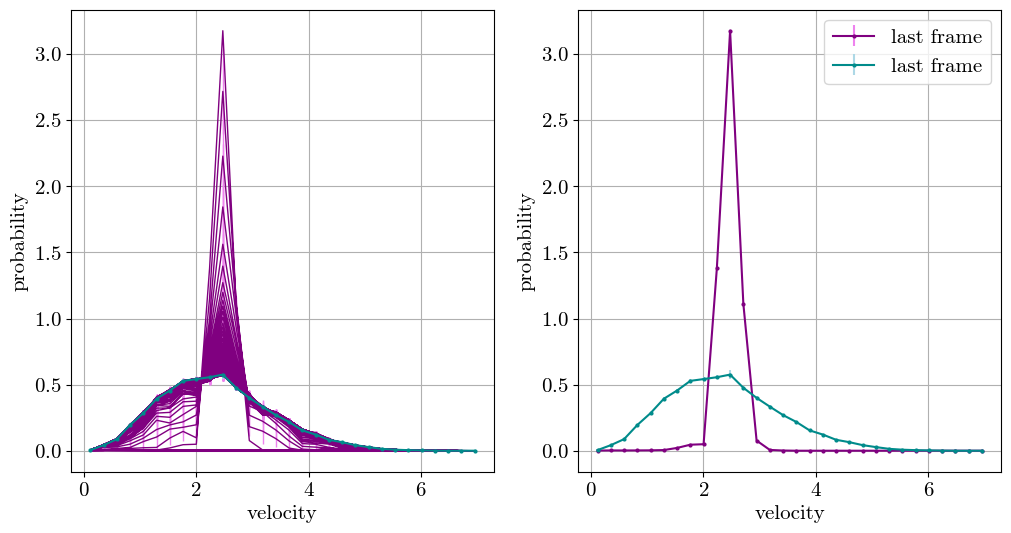

In [5]:
plt.figure(1, figsize=(12,6))
plt.subplot(1,2,1)
plt.errorbar(v,prob,err, ecolor= 'violet' ,color='purple', linewidth = 1)
plt.xlabel('velocity')
plt.ylabel('probability')
plt.grid(True)
plt.figure(1)
plt.errorbar(v_last, prob_last,err_last, marker = 'o', markersize = '2',color='darkcyan', ecolor='lightblue', label = 'last frame')


plt.figure(1)
plt.subplot(1,2,2)
plt.errorbar(v_first, prob_first,err_first, marker = 'o', markersize = '2',color='purple', ecolor='violet', label = 'last frame')
plt.errorbar(v_last, prob_last,err_last, marker = 'o', markersize = '2',color='darkcyan', ecolor='lightblue', label = 'last frame')
plt.xlabel('velocity')
plt.ylabel('probability')
plt.legend()
plt.grid(True)

1.9842557578927502


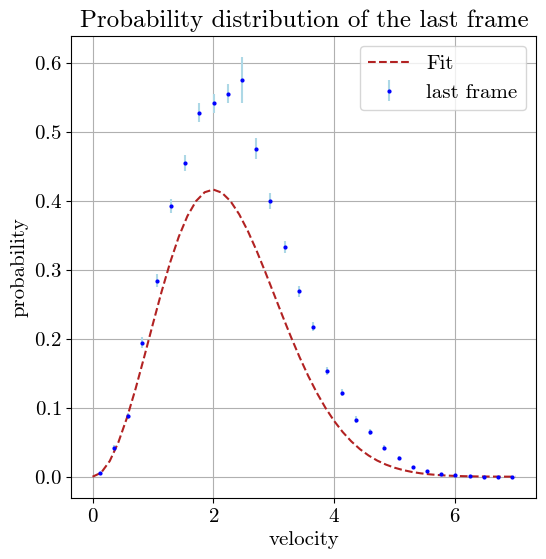

In [ ]:
def probability(x, a):
    return 2 * x**2 * np.exp((-x**2)/(2*a)) /(np.sqrt(2*np.pi*(a**3)))

plt.figure(1)
plt.errorbar(v_last, prob_last, err_last, marker = 'o', linestyle='none', markersize = '2',color='blue', ecolor='lightblue', label = 'last frame')
plt.xlabel('velocity')
plt.ylabel('probability')
plt.title('Probability distribution of the last frame')
plt.grid(True)
# Fit della curva
popt, pcov = curve_fit(probability, v_last, prob_last, p0=[1])

# Estraiamo i parametri ottimizzati
a_fit = popt[0]
print(popt[0])

# Creiamo i dati della curva fittata
x_fit = np.linspace(0, 7, 50)
y_fit = probability(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', label = 'Fit', color="firebrick")

plt.legend()

#non funziona il fit...


### Exercise 04.3

Starting from the final state of an **equilibrated** MD simulation of the system in Exercise 04.2, by changing the direction of time (e.g. by inverting the final velocities, i.e. ... ), try to return back to the very low entropic initial configuration of Exercise 04.2. Is this possible? (for example, one can monitor the behavior of the average **potential energy** and the average **temperature** in **each block** as a function of time going **in both directions**. Show some picture and comment on what you find in your jupyter-notebook.

Note:
- quando abbiamo raggiunto la distribuzione di max-boltz invertiamo l'asse dei tempi, invertendo le velocità (l'algoritmo di verlet è simmetrico per inversione temporale, ma non usa le velocità, quindi invertire le velocità deve essere tradotto in un altra cosa). riusciamo a tornare alla config a bassa entropia indietro? per vedere questo possiamo studiare cosa fa la temeratura o l'energia potenziale e vedere se è speculare al moto in andata.
Commentare quello che otteniamo 